In [1]:
# leaf_classification_3.ipynb
# ==============================================
# This notebook demonstrates classification using a combination of complementary features:
# - Color Histogram (HSV)
# - Local Binary Patterns (LBP)
# - Histogram of Oriented Gradients (HOG)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os                        # For file and directory operations
import cv2                       # OpenCV for image I/O and processing
import numpy as np               # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for visualization
from skimage.feature import local_binary_pattern      # LBP texture feature
from skimage.feature import hog                       # HOG feature extraction
from sklearn.model_selection import train_test_split  # To split data into train/test
from sklearn.preprocessing import StandardScaler      # For feature normalization
from sklearn.neighbors import KNeighborsClassifier    # k-NN classifier
from sklearn.tree import DecisionTreeClassifier       # Decision Tree classifier
from sklearn.metrics import classification_report, confusion_matrix  # For evaluation
from sklearn.preprocessing import LabelEncoder        # To encode labels

In [4]:
# 1. We in the start define dataset path and class names
base_dir = '/content/drive/MyDrive/archive/train/train'
class_names = [d for d in sorted(os.listdir(base_dir)) if os.path.isdir(os.path.join(base_dir, d))]

In [5]:
# 2. Defining feature extraction functions

def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract HSV color histogram features from an image.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert BGR to HSV color space
    # Compute histograms for H, S, and V channels
    h_hist = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])
    # Normalize and flatten
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()
    return np.hstack([h_hist, s_hist, v_hist])    # Concatenate into one vector


def extract_lbp_features(image, P=8, R=1):
    """
    Extract Local Binary Pattern (LBP) features from an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    lbp = local_binary_pattern(gray, P, R, method='uniform')  # Compute LBP
    n_bins = int(lbp.max() + 1)                             # Number of possible patterns
    # Compute histogram and normalize
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-6)
    return hist


def extract_hog_features(image, resize=(128, 128)):
    """
    Extract Histogram of Oriented Gradients (HOG) features from an image.
    """
    # Resize for consistent feature length
    img_resized = cv2.resize(image, resize)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    # Extract HOG features (no visualization needed here)
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features

In [6]:
# 3. Loading dataset and extract combined features
def load_and_extract(folder):
    """
    Load images and extract combined features for each image.
    Returns feature matrix X and label vector y.
    """
    X, y = [], []  # Lists for features and labels
    for cls in class_names:
        cls_folder = os.path.join(folder, cls)
        for file in os.listdir(cls_folder):
            if file.lower().endswith(('.jpg', '.png')):
                # Read image
                img_path = os.path.join(cls_folder, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip if cannot read
                # Extract features
                color_feats = extract_color_histogram(img)
                lbp_feats = extract_lbp_features(img)
                hog_feats = extract_hog_features(img)
                # Combine all features
                combined = np.hstack([color_feats, lbp_feats, hog_feats])
                X.append(combined)
                y.append(cls)
    return np.array(X), np.array(y)

# Execute loading and feature extraction
train_folder = os.path.join('/content/drive/MyDrive/archive/train', 'train')
X, y = load_and_extract(train_folder)
print(f"Extracted combined features shape: {X.shape}")

Extracted combined features shape: (4284, 8134)


In [7]:
# 4. Encode labels and split data
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert class names to integers
class_labels = le.classes_       # Save class order
# Splitting into train/test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [8]:
# 5. Normalize features
scaler = StandardScaler()         # Standardize features to zero mean and unit variance
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 6. Training classifiers
# a) k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
# b) Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [10]:
# 7. Evaluating models
print("k-NN Classification Report:")
print(classification_report(y_test, knn_pred, target_names=class_labels))
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred, target_names=class_labels))

k-NN Classification Report:
                    precision    recall  f1-score   support

Alstonia Scholaris       0.93      0.84      0.89        96
             Arjun       0.72      0.87      0.79        89
              Bael       0.93      0.72      0.81        18
             Basil       0.71      0.94      0.81        32
            Chinar       0.97      0.61      0.75        46
             Gauva       0.77      0.87      0.82        94
             Jamun       0.94      0.79      0.86       107
          Jatropha       1.00      0.40      0.58        52
             Lemon       0.78      0.83      0.80        42
             Mango       0.90      0.82      0.86        73
       Pomegranate       0.69      1.00      0.81        98
  Pongamia Pinnata       0.92      0.89      0.91       110

          accuracy                           0.82       857
         macro avg       0.85      0.80      0.81       857
      weighted avg       0.85      0.82      0.82       857

Decision 

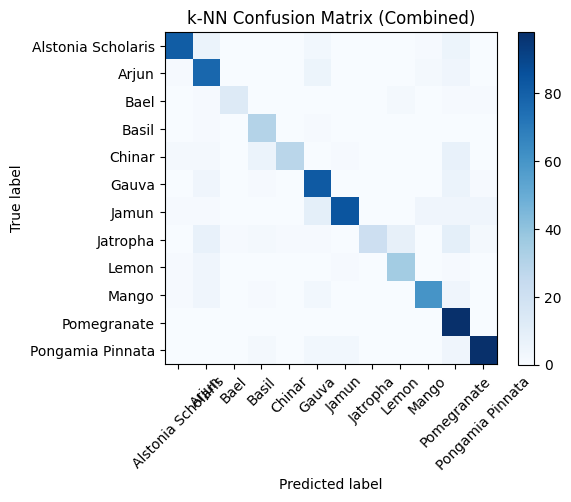

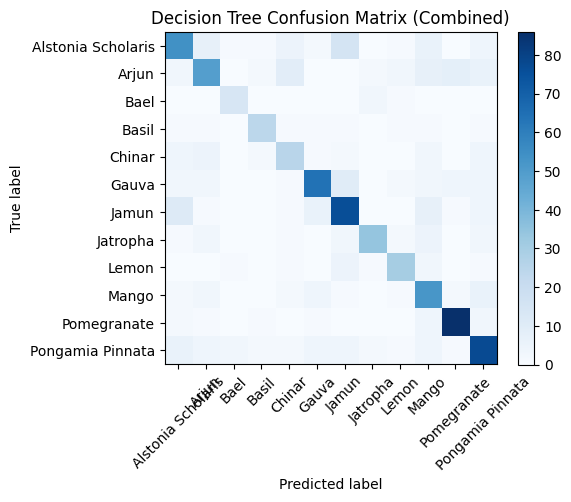

In [11]:
# 8. Plotting confusion matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, knn_pred, 'k-NN Confusion Matrix (Combined)')
plot_cm(y_test, dt_pred, 'Decision Tree Confusion Matrix (Combined)')

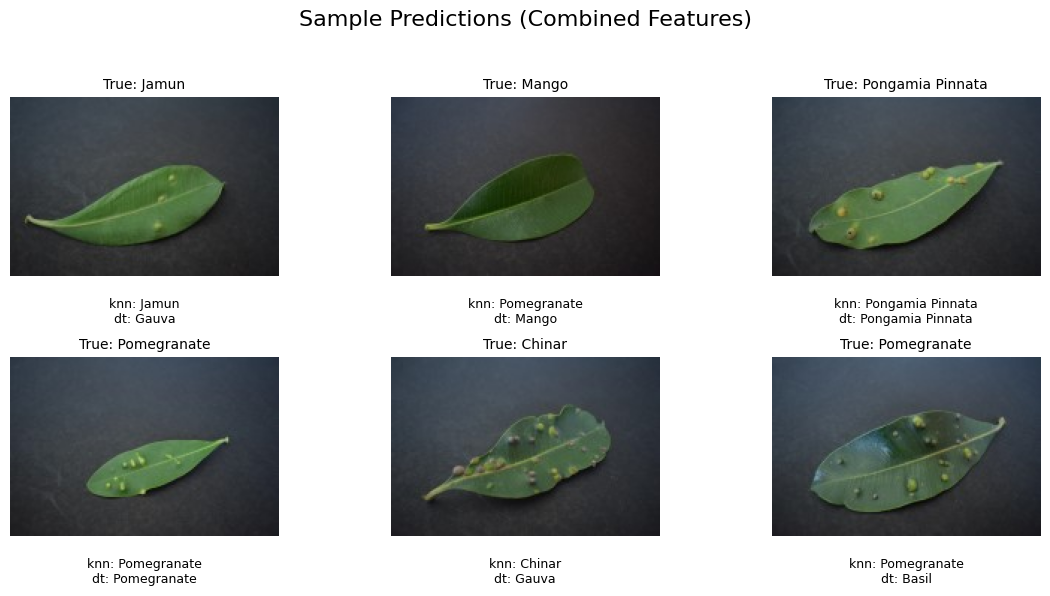

In [13]:
# 9. Sample predictions visualization
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
     # As we didn't store images here, reload for display
    img_path = os.path.join(train_folder, y[i], os.listdir(os.path.join(train_folder, y[i]))[i])
    img = cv2.imread(img_path)
    # Get predicted and true labels
    true_lbl = le.inverse_transform([y_test[i]])[0]
    knn_lbl = le.inverse_transform([knn_pred[i]])[0]
    dt_lbl = le.inverse_transform([dt_pred[i]])[0]
    # Show the image
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

    # Use a single-line title with manual line breaks, and shift it upward
    ax.set_title(f"True: {true_lbl}", fontsize=10, loc='center', pad=6)
    ax.text(0.5, -0.12, f"knn: {knn_lbl}\ndt: {dt_lbl}",
            size=9, ha="center", va="top", transform=ax.transAxes)

plt.suptitle('Sample Predictions (Combined Features)', fontsize=16)
plt.subplots_adjust(hspace=1)  # Increase vertical spacing between rows
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()